In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sctats

# **CPS 6:** Profit and Loss of the Black-Scholes hedging

## **1**

We want to simulate the Ornstein-Uhlenbeck process
$$
    d\sigma_t = \lambda(c-\sigma_t)\,dt + \gamma\, dW_t^{(2)}
$$
which has solution
$$
    \sigma_t = c + (\sigma_0-c)e^{-\lambda t} + \gamma\int_0^t e^{-\lambda(t-s)}\,dW_s^{(2)}.
$$

First we define a set of parameters for plotting and testing:

In [2]:
tmax = 1
n = 100
sig0 = 0.4
lbda = 2.0
c = 0.4
gamma = 0.3

In [88]:
def sigma_t(sig0, c, lbda, gamma, tmax, n, N=1000):
    """Ornstein-Uhlenbeck process.
    
    Args:
        N: number of copies (default=1000)
    
    Shape:
        N * n
    """
    dt = tmax/n
    dwt = np.zeros((n, N))
    dwt[1:] = np.sqrt(dt)*np.random.randn(n-1, N)
    times = np.linspace(0, tmax, n, endpoint=True)[:,None]
    integral_term = np.cumsum(np.exp(lbda*times)*dwt, axis=0)
    integral_term = np.exp(-lbda*times)*integral_term
    res = c + (sig0-c)*np.exp(-lbda*times) + gamma*integral_term
    return np.transpose(res)

We plot a single, example trajectory of the Ornstein-Uhlenbeck process (with a modified start value $\sigma_0 = 1.0$ to check the dynamics).

Text(0.5, 1.0, 'Volatility process $\\sigma_t$')

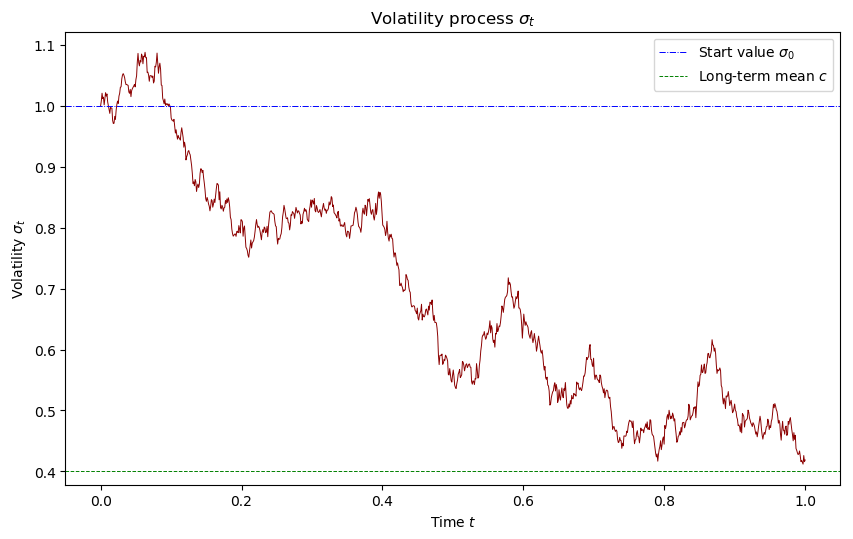

In [90]:
n = 1000
sig0 = 1.0 # different from c to check the dynamics
times = np.linspace(0, tmax, n, endpoint=True)
sig_trajectory = sigma_t(sig0, c, lbda, gamma, tmax, n, N=1)
plt.figure(figsize=(10,6), dpi=100)
plt.plot(times, sig_trajectory[0], linewidth=.7, c='darkred')
plt.xlabel('Time $t$')
plt.ylabel('Volatility $\sigma_t$')
plt.axhline(sig0, times.min(), times.max(), c='blue', linewidth=.7, linestyle='-.', label="Start value $\sigma_0$")
plt.axhline(c, times.min(), times.max(), c='green', linewidth=.7, linestyle='--', label="Long-term mean $c$")
plt.legend()
plt.title('Volatility process $\sigma_t$')

## **2**

In [146]:
def asset_price(S0, sig0, lbda, c, gamma, tmax, n, N=1000, sigma_traj=None):
    """Asset price process.
    
    Args:
        N: number of copies (default=1000)
        sigma_traj: volatility process (optional, generated by the function call), shape N * n
    
    Shape:
        N * n
    """
    # Realisation of sigma on [0, tmax]
    # if not supplied
    if sigma_traj is None:
        # Shape n * N
        sigma_traj = sigma_t(sig0, c, lbda, gamma, tmax, n-1, N=N).transpose()
    else:
        N = sigma_traj.shape[0]
        sigma_traj = sigma_traj[:,:-1].transpose()
    dt = tmax/n
    times = np.linspace(0, tmax, n, endpoint=True)
    # Volatility term: integral w.r.t. time (computed at discrete times < t)
    vol_integral = np.zeros((n, N))
    vol_integral[1:] = np.cumsum(np.power(sigma_traj, 2)*dt, axis=0)
    # Sample trajectories of second brownian process
    dwt = np.sqrt(dt)*np.random.randn(n-1, N)
    # Drift term: stochastic integral w.r.t. second brownian process
    drift_integral = np.zeros((n, N))
    drift_integral[1:] = np.cumsum(sigma_traj*dwt, axis=0)
    return S0*np.exp(-0.5*vol_integral + drift_integral).transpose()

In [147]:
S0 = 100
tmax = 1
n = 100
sig0 = 0.4
lbda = 2.0
c = 0.4
gamma = 0.3

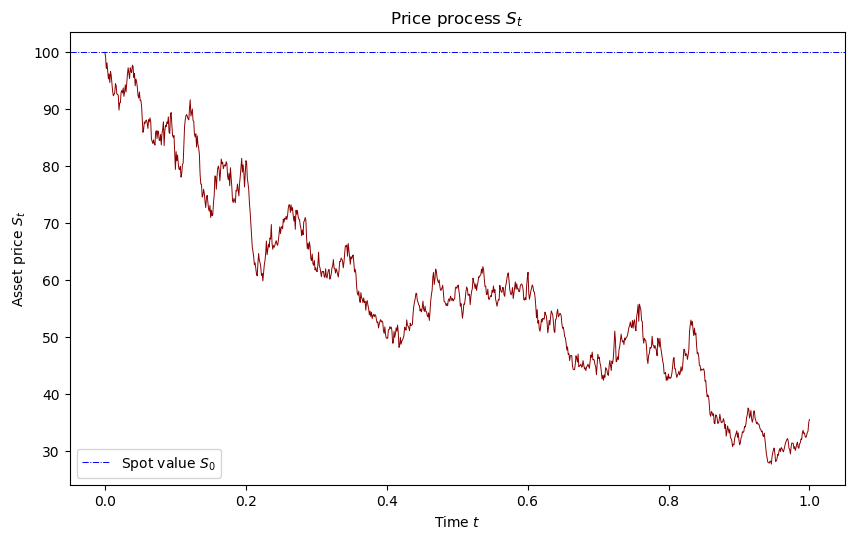

In [148]:
n = 1000
times = np.linspace(0, tmax, n, endpoint=True)
asset_trajectory = asset_price(S0, sig0, c, lbda, gamma, tmax, n, N=1)
plt.figure(figsize=(10,6), dpi=100)
plt.plot(times, asset_trajectory[0], linewidth=.7, c='darkred') # plot the first such trajectory
plt.xlabel('Time $t$')
plt.ylabel('Asset price $S_t$')
plt.title('Price process $S_t$')
plt.axhline(S0, times.min(), times.max(), c='blue', linewidth=.7, linestyle='-.', label="Spot value $S_0$")
plt.legend()

## **3**

On doit introduire la grecque
$$
    \Gamma(t, s, \Sigma) := \partial^2_{ss}C^{BS}(t, s, \Sigma).
$$

Puis le P&L
$$
    P\&L(\Sigma) = \frac12\int_0^T e^{r(T-u)} (\Sigma^2 - \sigma_u^2)S_u^2\Gamma^{BS}(u, S_u, \Sigma) \, du
$$

In [170]:
def BS_gamma(t, s, sigm, K):
    """
    Greek gamma; second derivative of the Black-Scholes call price.
    
    Args:
        t: time to maturity (maturity - current time)
    """
    s2T = sigm**2*t
    d1 = np.log(s/K)/np.sqrt(s2T) + 0.5*np.sqrt(s2T)
    return sctats.norm.pdf(d1)/(s*np.sqrt(s2T))

In [213]:
def prof_and_loss(sigm, r, K, S0, sig0, c, lbda, gamma, tmax, n, N):
    """
    Compute the profit and loss.
    
    Args:
        sigm: volatility
        r: interest rate
        K: option strike
    """
    dt = tmax/n
    # Compute volatility trajectories
    sigma_traj = sigma_t(sig0, c, lbda, gamma, tmax, n, N)
    # Compute asset price, shape n * N (after transpose)
    asset_traj = asset_price(S0, sig0, lbda, c, gamma, tmax, n, sigma_traj=sigma_traj)
    asset_traj = asset_traj.T[:-1]
    sigma_traj = sigma_traj.T[:-1]
    times = np.linspace(0, tmax, n)[:-1]
    # Shape N * n
    greek_gamma = BS_gamma(tmax - times[:,None], asset_traj, sigm, K)
    # Make the integrand, shape n * N
    integrand = np.exp(r*(tmax-times[:,None]))*(sigm**2 - sigma_traj**2)
    integrand *= asset_traj**2*greek_gamma
    integral_ =  np.sum(integrand*dt, axis=0)
    return 0.5*integral_

In [214]:
S0 = 100
tmax = 1
sig0 = 0.4
lbda = 2.0
c = 0.4
gamma = 0.3
sigm = sig0
r = 0.02
print("sigma0 = %.3f" % sig0)
print("lambda = %.3f" % lbda)
print("Σ = %.3f" % sigm)
print("r = %.3f" % r)
n = 100
N = 1000
print("No. of copies: %d" % N)

sigma0 = 0.400
lambda = 2.000
Σ = 0.400
r = 0.020
No. of copies: 1000


In [228]:
len(list(range(100,151,5)))

11

In [233]:
n_range = range(50,101,10)
K_range = range(105,151,5)
print(len(n_range))
print(len(K_range))

6
10


In [230]:
samples_matrix = np.empty((6, 10, N))
for i,n in enumerate(n_range):
    print('n = %d' % n)
    print('Strike\t\tMean\t\tVariance')
    for j,strike in enumerate(K_range):
        pnl_sample = prof_and_loss(sigm, r, strike, S0, sig0, c, lbda, gamma, tmax, n, N)
        samples_matrix[i, j, :] = pnl_sample
        sam_mean = pnl_sample.mean()
        sam_var = pnl_sample.var()
        print('%d\t\t%.3f\t\t%.3f' % (strike, sam_mean, sam_var))
    print()

n = 50
Strike		Mean		Variance
105		-0.647		15.399
110		-0.645		16.505
115		-0.650		17.406
120		-0.491		16.900
125		-0.340		15.425
130		-0.356		12.968
135		-0.400		12.165
140		-0.744		15.960
145		-0.541		14.102
150		-0.648		13.825

n = 60
Strike		Mean		Variance
105		-0.489		18.440
110		-0.472		16.247
115		-0.397		17.179
120		-0.648		15.581
125		-0.460		15.811
130		-0.717		18.489
135		-0.594		15.803
140		-0.829		15.971
145		-0.676		13.497
150		-0.934		15.085

n = 70
Strike		Mean		Variance
105		-0.413		14.816
110		-0.482		17.681
115		-0.578		18.092
120		-0.533		18.789
125		-0.586		17.479
130		-0.575		16.656
135		-0.761		13.482
140		-0.745		13.890
145		-0.615		16.184
150		-0.636		12.952

n = 80
Strike		Mean		Variance
105		-0.323		15.878
110		-0.563		17.718
115		-0.410		15.801
120		-0.523		16.657
125		-0.238		15.697
130		-0.485		15.240
135		-0.647		16.319
140		-0.545		15.317
145		-0.561		15.601
150		-0.702		13.307

n = 90
Strike		Mean		Variance
105		-0.493		15.699
110		-0.586		16.124
115		-

In [231]:
samples_matrix.shape

(6, 10, 1000)

In [232]:
means_matrix = samples_matrix.mean(axis=2)
varia_matrix = samples_matrix.var(axis=2)

In [240]:
means_matrix.shape

(6, 10)

In [242]:
list(K_range)

[105, 110, 115, 120, 125, 130, 135, 140, 145, 150]

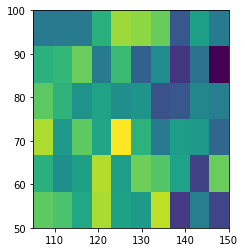

In [243]:
plt.imshow(means_matrix, extent=[105,150,50,100])